# Direct Asympt Local Tests
## local χ₀ Sum
This tests for the correct tails coefficients for χ₀ in local case.

In [73]:
testf = "/Users/user/Promotion/Daten/ED_out.jld2"
testfc = "/home/julian/Hamburg/ED_data/asympt_tests/config_14_small.toml"

using Plots
using OffsetArrays
using JLD2

using TimerOutputs
using Pkg
Pkg.activate("/home/julian/Hamburg/Julia_lDGA/LadderDGA.jl")
using LadderDGA
using FFTW


sum_freq_full_f! = LadderDGA.sum_freq_full_f!
get_symm_f = LadderDGA.get_symm_f
F_from_χ = LadderDGA.F_from_χ
to_m_index = LadderDGA.to_m_index
_eltype = ComplexF64;

#using LadderDGA.BSE_SC

  Activating project at `~/Hamburg/Julia_lDGA/LadderDGA.jl`


In [74]:
f = testf
cf = testfc
mP, sP, env, kGridsStr = readConfig(testfc);
@timeit LadderDGA.to "setup" Σ_ladderLoc, Σ_loc, imp_density, kG, gLoc, gLoc_fft, Γsp, Γch, χDMFTsp, χDMFTch, locQ_sp, locQ_ch, χ₀Loc, gImp = setup_LDGA(kGridsStr[1], mP, sP, env);
FUpDo = F_from_χ(0.5 * (χDMFTch .- χDMFTsp), gImp[1,:], sP, mP.β);
Fsp = F_from_χ(χDMFTsp, gImp[1,:], sP, mP.β);
Fch = F_from_χ(χDMFTch, gImp[1,:], sP, mP.β);
@timeit LadderDGA.to "nl bblt" bubble = calc_bubble(gLoc_fft, kG, mP, sP);
@timeit LadderDGA.to "nl xsp" nlQ_sp = calc_χγ(:sp, Γsp, bubble, kG, mP, sP);
@timeit LadderDGA.to "nl xch" nlQ_ch = calc_χγ(:ch, Γch, bubble, kG, mP, sP);
λ₀ = calc_λ0(bubble, Fsp, locQ_sp, mP, sP)
#Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, λ₀, gLoc_fft, kG, mP, sP);
#Σ_ladder_ν = kintegrate(kG, Σ_ladder, 1)[1,:];

[ Info: Reading Inputs...
[ Warning: Found Hubbard Parameters in input .jld2, ignoring config.toml
[ Warning: Frequency file not found, reconstructing grid from config.
[ Info: Setting up calculation for kGrid 3Dsc-0.2041241452319315 of size 4
[ Warning: Selfenergie now contains Hartree term and is cut to νmax = length(usable_ω)/3!
[ Info: setting usable ranges of sp and ch channel from 41:61 and 41:61 to the same range of 41:61
[ Warning: TODO: update local omega sum with correction, update get_sum_helper to return tail sub
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(41:61) = 0.319, χLoc_ch(41:61) = 0.1339
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.20381585102788577 ?=? 0.22642432530788006 ?≈? 0.22642432530788006 ?≈? 0.25"


In [192]:
function scKGrid(ksteps :: Int64)
    kGrid = Array{NTuple{3,Float64},1}(undef,ksteps^3)
    #[(2*π/Nk) * j - π for j in 1:Nk]
    ki_monkhorst = [(2*i - ksteps )/(2*ksteps) for i in 1:ksteps]
    for kx in 0:ksteps-1 
        for ky in 0:ksteps-1
            for kz in 0:ksteps-1
                kGrid[kx*ksteps^2+ky*ksteps+kz+1] = (2*pi*ki_monkhorst[kx+1],
                 2*pi*ki_monkhorst[ky+1],
                 2*pi*ki_monkhorst[kz+1])
            end
        end
    end 
    return kGrid
end

using ShiftedArrays

function calc_bubble_notebook(Gνω, kG, kG_red, β, νgrid, ωgrid)
    data = Array{ComplexF64,3}(undef, length(kG.kGrid), length(νgrid), length(ωgrid))
    ifft_post(x) = ShiftedArrays.circshift(x, floor.(Int, gridshape(kG) ./ 2) .+ 1)
    for (ωi,ωn) in enumerate(ωgrid)
        for (νi,νn) in enumerate(νgrid)
            v1 = fft(reshape(Gνω[:,ωn],gridshape(kG)))
            v2 = fft(reshape(Gνω[:,νn+ωn],gridshape(kG)))
            data[:,νi,ωi] = -β .* ifft_post(ifft(v1 .* v2))[:] ./ Dispersions.Nk(kG)
        end
    end

    return data
end

function naive_bubble(fk::FullKGrid{T}, νgrid) where T
    ωn = 0
    
    Σ_loc = 0#2.734962277113537 - 0.41638191263582125im
    β = 14.0
    μ = 0.5
    disp(ki) = Dispersions.gen_ϵkGrid(T, [ki], fk.t)[1]
    res = zeros(Complex{Float64}, length(fk.kGrid), length(νgrid))
    for (νi, νn) in enumerate(νgrid)
    for (kii,ki) in enumerate(fk.kGrid)
        for (qii,qi) in enumerate(fk.kGrid)
            Σ_int_ωn = Σ_loc
            Σ_int_ωn_νn = Σ_loc
            w1 = 1im * (π*(2*ωn+1)/β) + μ - disp(ki)
            w2 = 1im * (π*(2*(ωn+νn)+1)/β) + μ - disp(ki .+ qi)
            res[qii,νi] = res[qii,νi] - 1.0 / (w1 * w2)
        end
    end
    end
    return β .* res ./ length(fk.kGrid)
end

function naive_conv(kG::ReducedKGrid, arr1::AbstractArray, arr2::AbstractArray)
    Nk(kG) == 1 && return arr1 .* arr2
    a1 = expandKArr(kG, arr1)
    a2 = expandKArr(kG, arr2)
    res = zeros(eltype(arr1), size(a1))
    mi = size(a2)
    for j in CartesianIndices(a2)
        for i in CartesianIndices(a1)
            ii = mod1.(Tuple(j) .+ Tuple(i) .- Tuple(ones(Int,length(i))), size(a1))
            res[j] += a1[j]*a2[ii...]
        end
    end
    return res ./ Nk(kG)
end

naive_conv (generic function with 1 method)

In [218]:
using Dispersions
Nki = 6;

kPoints= scKGrid(Nk);
kGrid = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", Nki)
kGrid_full = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", Nki,full=true)
νGrid = -2*(sP.n_iν + sP.n_iω):2*(sP.n_iν + sP.n_iω) 

nd = 3
G_fft = OffsetArray(Array{ComplexF64, 2}(undef, length(kGrid_full.kGrid), length(νGrid)), 1:length(kGrid_full.kGrid), νGrid)
GTest = OffsetArray(Array{ComplexF64,2}(undef, length(kGrid_full.kGrid), length(νGrid)), 1:length(kGrid_full.kGrid), νGrid)
G_manual = OffsetArray(Array{ComplexF64, 2}(undef, Dispersions.Nk(kGrid_full), length(νGrid)),1:Dispersions.Nk(kGrid_full),νGrid)

for (νi,νn) in enumerate(νGrid)
    for (ki,ϵₖ) in enumerate(kGrid_full.ϵkGrid)
        GTest[ki,νn] = 1/((π/mP.β)*(2*νn + 1)*1im - mP.μ + ϵₖ)
    end
    #expanded_arr = expandKArr(kGrid, GTest[:,νn].parent)
    G_manual[:,νn]=GTest[:,νn]
    G_fft[:,νn]=fft(reshape(GTest[:,νn],gridshape(kGrid_full)...))[:]
    #selectdim(G_fft,nd+1,νi) .= fft(reshape(G_manual[:,νi], gridshape(kGrid_full)...))
end

In [219]:
#bubble_test = calc_bubble(G_fft, kGrid, mP, sP);
bubble_test2 = naive_bubble(kGrid_full, -100:100);

In [228]:
reduceKArr(kGrid, reshape(bubble_test2[:,101], gridshape(kGrid_full)))

20-element Vector{ComplexF64}:
  -0.4088367432241075 - 0.28582773372447207im
 -0.40852698786940805 - 0.2853075698933779im
  -0.4082178914184648 - 0.28479063462862253im
 -0.40790947353298207 - 0.2842768896934254im
  -0.4079077498126142 - 0.2842702210084252im
  -0.4075999701954596 - 0.2837596975443102im
  -0.4072929076842535 - 0.2832522887288432im
 -0.40698468049265996 - 0.2827414940781846im
  -0.4066790489121383 - 0.28224027158503856im
  -0.4060680453599244 - 0.2812405417533503im
 -0.40759825930477017 - 0.2837530459705503im
  -0.4072911377212549 - 0.283245706134127im
 -0.40698475213580315 - 0.2827414434960736im
 -0.40667716289524086 - 0.282233825256913im
  -0.4063722452823156 - 0.28173567481251843im
 -0.40576266628599017 - 0.28074204670576225im
 -0.40637030222771714 - 0.28172929577600514im
  -0.4060661167447257 - 0.28123418069596196im
 -0.40545799792422316 - 0.280246581695592im
  -0.4051540577441419 - 0.27975411078281376im

In [231]:
bubble_test2[:,201]

216-element Vector{ComplexF64}:
   6.150055167889208 + 39.89833824778601im
  11.308741277501326 + 35.053310444959884im
  13.760573486867095 + 32.61167100576044im
  11.308741277501337 + 35.05331044495988im
   6.150055167889211 + 39.89833824778602im
  2.0159484140571418 + 42.519464714435905im
   11.30874127750133 + 35.05331044495988im
   13.91935583620829 + 30.40160834969368im
   12.79572338184241 + 28.011866814435308im
  13.919355836208288 + 30.401608349693674im
   11.30874127750134 + 35.05331044495987im
  12.230567770663082 + 37.966506567860584im
  13.760573486867091 + 32.61167100576042im
                     ⋮
  2.0159484140571524 + 42.51946471443588im
  12.230567770663082 + 37.96650656786057im
  14.835245623629836 + 35.54061757774655im
  12.230567770663086 + 37.966506567860584im
  2.0159484140571613 + 42.51946471443589im
 -3.8133389972441014 + 42.15098882486529im
 -3.8133389972441107 + 42.15098882486528im
   7.393827692121579 + 44.84890663335636im
  13.384762575583284 + 42.9022486261

In [232]:
testdata[:,6,2]

216-element Vector{ComplexF64}:
   6.150055167889185 - 39.89833824778597im
   11.30874127750133 - 35.05331044495987im
  13.760573486867074 - 32.611671005760385im
   11.30874127750134 - 35.05331044495986im
   6.150055167889194 - 39.898338247785965im
  2.0159484140571213 - 42.519464714435884im
  11.308741277501335 - 35.05331044495986im
  13.919355836208274 - 30.40160834969367im
  12.795723381842425 - 28.011866814435308im
  13.919355836208275 - 30.401608349693667im
  11.308741277501335 - 35.053310444959855im
  12.230567770663065 - 37.96650656786059im
  13.760573486867075 - 32.611671005760385im
                     ⋮
   2.015948414057142 - 42.519464714435856im
  12.230567770663065 - 37.96650656786057im
  14.835245623629836 - 35.54061757774653im
  12.230567770663084 - 37.96650656786056im
   2.015948414057158 - 42.519464714435856im
 -3.8133389972441027 - 42.150988824865266im
 -3.8133389972441156 - 42.15098882486526im
   7.393827692121549 - 44.848906633356314im
  13.384762575583276 - 42.90224

In [227]:
reduceKArr(kGrid, reshape(testdata[:,6,2], gridshape(kGrid_full)))

20-element Vector{ComplexF64}:
  12.743292694481786 - 27.542742091845202im
  12.644594632875949 - 26.693864655617446im
   14.71742289300197 - 28.072021953991015im
   11.31479318728666 - 27.701606479425408im
   12.90452626141004 - 25.67474730089031im
  12.795723381842427 - 28.011866814435304im
  13.919355836208288 - 30.401608349693646im
  13.760573486867072 - 32.61167100576037im
  11.308741277501342 - 35.05331044495984im
   6.150055167889217 - 39.89833824778595im
   14.90099553991949 - 23.482226741502878im
  15.156990489515625 - 26.668688343037097im
  11.832149161378279 - 29.84840720476897im
  14.835245623629833 - 35.54061757774653im
  12.230567770663082 - 37.96650656786056im
  2.0159484140571546 - 42.51946471443586im
  13.384762575583274 - 42.902248626178206im
    7.39382769212157 - 44.848906633356314im
 -3.8133389972441054 - 42.15098882486527im
  -7.886140599231732 - 39.60952651800204im

In [221]:
testdata=calc_bubble_notebook(G_manual,kGrid_full, kGrid,14.0,-5:5,-1:1)
reduceKArr(kGrid, reshape(testdata[:,6,2], gridshape(kGrid)))

20-element Vector{ComplexF64}:
  12.743292694481786 - 27.542742091845202im
  12.644594632875949 - 26.693864655617446im
   14.71742289300197 - 28.072021953991015im
   11.31479318728666 - 27.701606479425408im
   12.90452626141004 - 25.67474730089031im
  12.795723381842427 - 28.011866814435304im
  13.919355836208288 - 30.401608349693646im
  13.760573486867072 - 32.61167100576037im
  11.308741277501342 - 35.05331044495984im
   6.150055167889217 - 39.89833824778595im
   14.90099553991949 - 23.482226741502878im
  15.156990489515625 - 26.668688343037097im
  11.832149161378279 - 29.84840720476897im
  14.835245623629833 - 35.54061757774653im
  12.230567770663082 - 37.96650656786056im
  2.0159484140571546 - 42.51946471443586im
  13.384762575583274 - 42.902248626178206im
    7.39382769212157 - 44.848906633356314im
 -3.8133389972441054 - 42.15098882486527im
  -7.886140599231732 - 39.60952651800204im

In [ ]:
using Dispersions
Nk = 20;

kPoints= ScKGrid(Nk);
kGrid = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", Nk)
kGrid_full = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", Nk,full=true)
νGrid = -2*(sP.n_iν + sP.n_iω):2*(sP.n_iν + sP.n_iω) 

nd = 3
G_fft = Array{ComplexF64, nd+1}(undef, gridshape(kGrid)..., length(νGrid))
GTest = OffsetArray(Array{ComplexF64,2}(undef, length(kGrid_full.kGrid), length(νGrid)), 1:length(kGrid_full.kGrid), νGrid)
G_manual = Array{ComplexF64, 2}(undef, Nk^3, length(νGrid))

for (νi,νn) in enumerate(νGrid)
    for (ki,ϵₖ) in enumerate(kGrid_full.ϵkGrid)
        GTest[ki,νn] = 1/((π/mP.β)*(2*νn + 1)*1im - mP.μ + ϵₖ)
    end
    #expanded_arr = expandKArr(kGrid, GTest[:,νn].parent)
    G_manual[:,νi]=GTest[:,νn]
    selectdim(G_fft,nd+1,νi) .= fft(reshape(G_manual[:,νi], gridshape(kGrid_full)...))
end

In [437]:
mP.μ

0.5

In [357]:
kGrid_full = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", Nk,full=true)

cP(t=0.2041241452319315) grid in 3 dimensions with 125 k-points.

In [388]:
Γ_to_X = findall(x -> (x[2] ≈ 0) && (x[3] ≈ 0), kGrid.kGrid)[1:end-1]
X_to_M = findall(x -> (x[1] ≈ π) && (x[3] ≈ 0), kGrid.kGrid)[1:end-1]
M_to_Γ = reverse(findall(x -> (x[1] ≈ x[2]) && (x[3] ≈ 0), kGrid.kGrid))[1:end-1]
Γ_to_R = findall(x -> (x[1] ≈ x[2]) && (x[3] ≈ x[2]), kGrid.kGrid)[1:end-1];
path = cat(Γ_to_X, X_to_M, M_to_Γ, Γ_to_R, dims=1);

In [392]:
Γ_to_X = findall(x -> (x[2] ≈ 0) && (x[3] ≈ 0), kGrid_full.kGrid)[1:end-1]
X_to_M = findall(x -> (x[1] ≈ π) && (x[3] ≈ 0), kGrid_full.kGrid)[1:end-1]
M_to_Γ = reverse(findall(x -> (x[1] ≈ x[2]) && (x[3] ≈ 0), kGrid_full.kGrid))[1:end-1]
Γ_to_R = findall(x -> (x[1] ≈ x[2]) && (x[3] ≈ x[2]), kGrid_full.kGrid)[1:end-1];
path = cat(Γ_to_X, X_to_M, M_to_Γ, Γ_to_R, dims=1);

In [365]:
testi=findall(x -> x[1]==x[2] && x[3]==x[2],kGrid_full.kGrid)
kGrid_full.kGrid[testi]

5-element Vector{Tuple{Float64, Float64, Float64}}:
 (-1.8849555921538759, -1.8849555921538759, -1.8849555921538759)
 (-0.6283185307179586, -0.6283185307179586, -0.6283185307179586)
 (0.6283185307179586, 0.6283185307179586, 0.6283185307179586)
 (1.8849555921538759, 1.8849555921538759, 1.8849555921538759)
 (3.141592653589793, 3.141592653589793, 3.141592653589793)

In [373]:
kVectors = vec(kGrid_full.kGrid)
#println(kVectors)
bubble = zeros(ComplexF64,length(path))
for (qi,q) in enumerate(path)
    for i in 1:length(G_manual[:,1])
        kq=[0.0,0.0,0.0]
        for k in 1:3
            println("a($k): ", kVectors[i][k]+kGrid_full.kGrid[q][k])
            if isapprox(kVectors[i][k]+kGrid_full.kGrid[q][k],-π,atol=1e-8)
                kq[k]=π
            elseif isapprox(kVectors[i][k]+kGrid_full.kGrid[q][k],π,atol=1e-8)
                kq[k]=π
            elseif kVectors[i][k]+kGrid_full.kGrid[q][k] >=0
                kq[k]=mod(kVectors[i][k]+kGrid_full.kGrid[q][k]+π,2*π)-π
            else
                kq[k]=mod(-(kVectors[i][k]+kGrid_full.kGrid[q][k])+π,2*π)-π
            end
        end
        kqi = findfirst(x -> isapprox(x[1],kq[1],atol=1e-8) && isapprox(x[2],kq[2],atol=1e-8) && isapprox(x[3],kq[3],atol=0.00000000001),kVectors)    
        println(kq)
        println(kqi)
        for j in 1:length(G_manual[1,:])
            bubble[qi]+=G_manual[i,j]*G_manual[kqi,j]
        end
    end
    bubble[qi] = -mP.β*bubble[qi]/(length(G_manual[:,1])*length(G_manual[1,:]))
end

a(1): -3.7699111843077517
a(2): -3.7699111843077517
a(3): -3.7699111843077517
[-2.5132741228718345, -2.5132741228718345, -2.5132741228718345]
nothing


LoadError: ArgumentError: invalid index: nothing of type Nothing

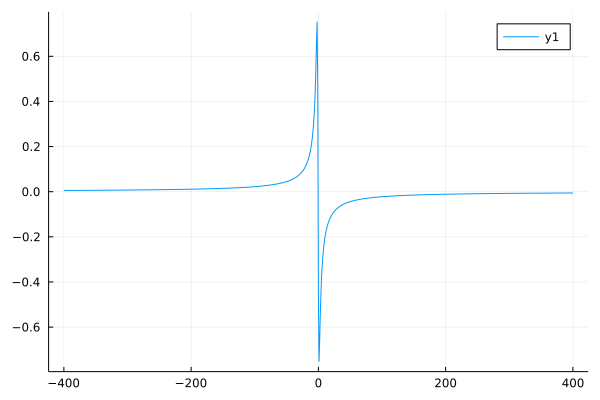

In [436]:
plot(imag(G_manual[1,:]))

In [428]:
bubble

4-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

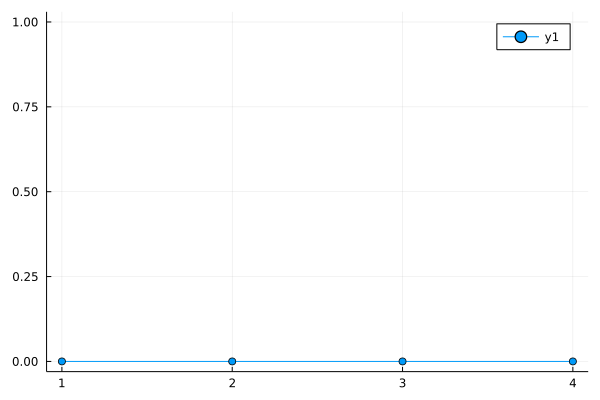

In [427]:
plot(real(bubble),markershape=:auto)

In [395]:
#G_re=reshape(GTest,(4,4,4,length(νGrid)))
#G_fft = FFTW.fft(G_re)
#print(size(G_fft))
#print(kGrid.kGrid)
χ₀_qνω = LadderDGA.calc_bubble(G_fft, kGrid, mP, sP).data;
χ₀_qω  = sum(χ₀_qνω, dims=2)[:,1,:]/mP.β;

LoadError: MethodError: no method matching calc_bubble(::Array{ComplexF64, 4}, ::Dispersions.FullKGrid_cP{3}, ::ModelParameters, ::SimulationParameters)
[0mClosest candidates are:
[0m  calc_bubble(::Array, [91m::ReducedKGrid[39m, ::ModelParameters, ::SimulationParameters; local_tail) at ~/Promotion/Gits/LadderDGA.jl/src/ladderDGATools.jl:37

In [396]:
plot(real(χ₀_qω[path,101]) ,markershape=:auto)

LoadError: BoundsError: attempt to access 286×201 Matrix{ComplexF64} at index [[3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790  …  3790, 4211, 4632, 5053, 5474, 5895, 6316, 6737, 7158, 7579], 101]

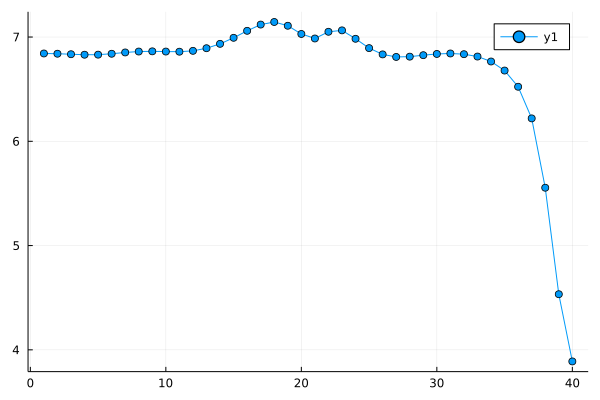

In [248]:
plot(real(χ₀_qω[path,101]) ,markershape=:auto)

In [230]:
using NPZ
npzwrite("/Users/user/Promotion/RPA/data/SC/datenJulian.npy",χ₀_qω[path,101])

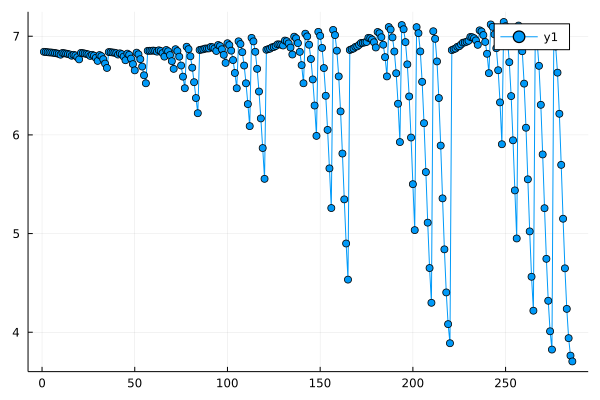

In [173]:
plot(real(χ₀_qω[:,101]),markershape=:auto)

In [153]:
kGrid = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", 2)
D        = 3
Nk       = 4
kG_n     = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", Nk)



sampling = [(2*π/Nk) * j - π for j in 1:Nk]
kGrid    = collect(Base.product([sampling for Di in 1:D]...))
kGrid_lin = kGrid[:]
kGrid_red = Dispersions.reduceKArr(kG, kGrid);
νGrid     = -2*(sP.n_iν + sP.n_iω):2*(sP.n_iν + sP.n_iω) 
Σ_loc_os = OffsetArray(cat(conj(reverse(Σ_loc)),Σ_loc, dims=1),-length(Σ_loc):length(Σ_loc)-1)
gLoc_full = OffsetArray(Array{ComplexF64,2}(undef, length(kGrid), length(νGrid)), 1:length(kGrid), νGrid)

for (ki,k) in enumerate(kGrid_lin)
    ϵₖ = -2*kG.t*sum(cos.(k))
    for (νi,νn) in enumerate(νGrid)
        gLoc_full[ki,νn] = 1/((π/mP.β)*(2νn + 1)*1im + mP.μ - ϵₖ - Σ_loc_os[νn])
    end
end

testGimp_f,testGimp,testGimp_fft = calc_χ₀_notebook(gImp, kGridLoc, mP, sP);
testGLoc_f,testGLoc,testGLoc_fft = calc_χ₀_notebook(gLoc_full, kG_n, mP, sP);

LoadError: UndefVarError: calc_χ₀_notebook not defined

In [ ]:
using Test
using OffsetArrays
using JLD2
using Plots
include("../src/ladderDGA_core.jl")
include("../src/helpers.jl")
include("../src/IO.jl")
include("../src/build_chi_asympt.jl")
include("../src/dbg_tools.jl")
Nν_shell = 10
testf = "/home/julian/Hamburg/ED_data/asympt_tests/ED_b14u1_small.jld2"#"../test/test_data/ED_s1.jld2"
#testf = "/home/julian/Hamburg/ED_data/asympt_tests/ED_b14u1.jld2"
#testf = "/home/julian/Hamburg/ED_data/asympt_tests/ED_b08u2_small.jld2"#"../test/test_data/ED_s1.jld2"

gImp_loc_test, χ₀_loc_test, χsp_loc_test, χch_loc_test, helper, U, β = setup(testf, Nν_shell);

test_lambda = "/home/julian/Hamburg/ED_data/asympt_tests/b14u1_lambda.jld2"
λch_ed_asym, λsp_ed_asym, λpp_ed_asym = load(test_lambda, "λch", "λsp", "λpp");
λch_ed_amp_asym, λsp_ed_amp_asym, λpp_ed_amp_asym = load(test_lambda, "λch_amp", "λsp_amp", "λpp_amp");
γch_ed_asym, γsp_ed_asym, γpp_ed_asym = load(test_lambda, "γch", "γsp", "γpp");
χsp_ed, χch_ed = load(testf, "χ_sp_asympt","χ_ch_asympt") ./ β^2 ;

f = jldopen(testf, "r")
FUpDo = permutedims(f["FUpDo"],(2,3,1));
Σ_loc_in = 1 ./ f["g0"] .- 1 ./ f["gImp"];
sVk = sum(f["Vₖ"].^2)
n = f["nden"]
μ = f["μ"]
n_iν = f["grid_nFermi"]
shift = f["grid_shift"]
close(f)

function χ₀_shell_sum_core_notebook(β::Float64, ω_ind_grid::AbstractVector{Int}, n_iν::Int, shift)
   res = OffsetArray(zeros(ComplexF64, length(ω_ind_grid), 4), ω_ind_grid, 1:4)
   iω_grid = iω_array(β, ω_ind_grid)
   for ωn in ω_ind_grid
        si = shift*trunc(Int,ωn/2)
        iν_ind_grid = (-n_iν-abs(minimum(ω_ind_grid))-si):(n_iν+abs(maximum(ω_ind_grid))-si-1)
        iν_grid = OffsetArray(iν_array(β, iν_ind_grid), iν_ind_grid)
        for νn in (-n_iν-si):(n_iν-si-1)
            res[ωn,1] += 1/(iν_grid[νn]^1 * iν_grid[νn+ωn]^1) 
            res[ωn,2] += 1/(iν_grid[νn]^2 * iν_grid[νn+ωn]^1) + 1/(iν_grid[νn]^1 * iν_grid[νn+ωn]^2) 
            res[ωn,3] += 1/(iν_grid[νn]^2 * iν_grid[νn+ωn]^2) 
            res[ωn,4] += 1/(iν_grid[νn]^3 * iν_grid[νn+ωn]^1) + 1/(iν_grid[νn]^1 * iν_grid[νn+ωn]^3) 
        end
    end
    return res
end

function χ₀_shell_sum_notebook(core::OffsetArray{ComplexF64,2}, ωn::Int, β::Float64, c1::Float64, c2::Float64, c3::Float64)::ComplexF64
    res = (core[ωn,1] + c1*core[ωn,2] + c2*core[ωn,3] + c3*core[ωn,4])/β
    ωn2 = 2*(2*ωn*π/β)^2
    res += ωn == 0 ? (β/4-c2*β^3/48-c3*β^3/24) : ((c3-c2)*β/ωn2)
    return res
end

function calc_χλ_notebook(type::Symbol, shell_sum_core, ωn::Int, χ::AbstractArray{ComplexF64,2}, χ₀::AbstractArray{ComplexF64,1}, U::Float64, β::Float64, c1::Float64, c2::Float64, c3::Float64, h::BSE_Asym_Helper)
    bs = -χ₀_shell_sum_notebook(shell_sum_core, ωn, β, c1, c2, c3)
    s = type == :ch ? -1 : 1
    ind_core = (h.Nν_shell+1):(size(χ₀,1)-h.Nν_shell)
    χ₀_core = view(χ₀,ind_core)
    λ_core = -s*sum(χ,dims=[2])[:,1] ./ χ₀_core .+ s
    χ_core = sum(χ) /β^2
    F_diag!(type, ωn, U, β, χ₀, h)
    λ = (λ_core .- s*view(h.diag_asym_buffer, ind_core) .+ U*bs)/(1+s*U*bs)
    λ_s = -sum((U .* λ .- s*U) .* χ₀_core)/β^2
    diag_asym_s = -sum(h.diag_asym_buffer .* χ₀)/β^2
    χ = (χ_core - bs*(1+2*λ_s-s*U*bs) - diag_asym_s)/(1-U^2 * bs^2)
    return χ, λ
end

In [ ]:
c2_old = μ-U*(n/2)
c3_old = (μ-U*(n/2))^2 + sVk + U^2 * (n/2) * (1 - n/2);

c1 = U*n/2 - μ
c2 = [(U*n/2 - μ) ^ 2]
c3 = (μ-U*(n/2))^2 + sVk + U^2 * (n/2) * (1 - n/2)

n_iω = trunc(Int, size(χsp_loc_test,3)/2);
bs_old = calc_χ₀_shell_sum_old(β, c2_old, c3_old, n_iω, n_iν, shift);
χ₀_core = χ₀_shell_sum_core_notebook(β, -n_iω:n_iω, n_iν, shift)
bs = map(x -> χ₀_shell_sum_notebook(χ₀_core, x, β, c1, c2[1], c3), -n_iω:n_iω);
h = helper;
println("max(|old - (-new)|) computation: ", maximum(abs.(bs_old .+ bs)))

In [ ]:
ωi = 52
ωn = ωi - n_iω - 1

χsp_asym,χch_asym,λsp_asym,λch_asym,tsp,tch = improve_χλ_direct(ωn, χsp_loc_test[:,:,ωi], χch_loc_test[:,:,ωi],
                                                                view(χ₀_loc_test,:,ωi), U, β, bs_old[ωi], helper);;

χsp_ω_loc_test = Array{Float64,1}(undef, size(χsp_loc_test,3))
χch_ω_loc_test = Array{Float64,1}(undef, size(χch_loc_test,3))
λsp_ω_loc_test = Array{ComplexF64,2}(undef, 2*n_iν, size(χsp_loc_test,3))
λch_ω_loc_test = Array{ComplexF64,2}(undef, 2*n_iν, size(χch_loc_test,3))
χsp_ω_int_loc_test = Array{ComplexF64,1}(undef, size(χsp_loc_test,3))
χch_ω_int_loc_test = Array{ComplexF64,1}(undef, size(χch_loc_test,3))
λsp_ω_int_loc_test = Array{ComplexF64,2}(undef, 2*n_iν, size(χsp_loc_test,3))
λch_ω_int_loc_test = Array{ComplexF64,2}(undef, 2*n_iν, size(χch_loc_test,3))
bs = calc_χ₀_shell_sum_old(β, c2_old, c3_old, n_iω, n_iν, shift);

χ₀_core = sum(χ₀_loc_test[11:110,:], dims=[1])[1,:] ./ β^2 
χ₀_res1 = zeros(size(χ₀_core))
χ₀_res2 = zeros(size(χ₀_core))
χ₀_res3 = zeros(size(χ₀_core))
χ₀_rest = χ₀_shell_sum_core_notebook(β, -n_iω:n_iω, n_iν, Int(shift))
for ωi in 1:size(χch_loc_test,3)
    ωn = ωi - n_iω - 1
    χsp_asym,χch_asym,λsp_asym,λch_asym, λsp_core, λch_core = improve_χλ_direct(ωn, χsp_loc_test[:,:,ωi], χch_loc_test[:,:,ωi],
                                                            view(χ₀_loc_test,:,ωi), U, β, bs[ωi], helper);
    χsp_ω_int_loc_test[ωi],λsp_ω_int_loc_test[:,ωi] = calc_χλ_notebook(:sp, χ₀_rest, ωn, χsp_loc_test[:,:,ωi],view(χ₀_loc_test,:,ωi), 
                            U, β, c1, c2[1], c3, helper);
    χch_ω_int_loc_test[ωi],λch_ω_int_loc_test[:,ωi] = calc_χλ_notebook(:ch, χ₀_rest, ωn, χch_loc_test[:,:,ωi],view(χ₀_loc_test,:,ωi), 
                            U, β, c1, c2[1], c3, helper);
    λsp_ω_loc_test[:,ωi] = λsp_asym
    λch_ω_loc_test[:,ωi] = λch_asym
    χsp_ω_loc_test[ωi] = real(χsp_asym)
    χch_ω_loc_test[ωi] = real(χch_asym)
    
    χ₀_asym = χ₀_shell_sum_notebook(χ₀_rest, ωn, β, c1, c2[1], c3)
    χ₀_res1[ωi] = real((χ₀_core[ωi]) )
    χ₀_res2[ωi] = real((χ₀_core[ωi] + χ₀_asym))
    χ₀_res3[ωi] = real((χ₀_core[ωi] + χ₀_asym) * (2*ωn*π/β)^2)
end

plot(χ₀_res1[:], markershape=:auto, label="plain sum")
plot!(χ₀_res2[:], markershape=:auto, label="improved sum")
plot!(χ₀_res3[:], markershape=:auto, label="ω^2 tail")

In [ ]:
max_diff = round(maximum(abs.(real(χsp_ed[(0:n_iω) .+ 1] .- χsp_ω_int_loc_test[n_iω+1:end]))), digits=5)
plot(-n_iω:n_iω,real(χsp_ω_int_loc_test[:]), title="ED-Improved max Δ = $(max_diff)",xlabel="ωₙ", ylabel="χsp", markershape=:auto, label="χsp improved")
plot!(-n_iω:n_iω,χsp_ω_loc_test, label="χsp improved (old)")
plot!(-n_iω:n_iω,real(locQ_sp.χ[1,:]), label="χsp internal", linewidth=2)
plot!(0:n_iω, real(χsp_ed[(0:n_iω) .+ 1]), label="exact ED")

In [ ]:
max_diff = round(maximum(abs.(real(χch_ed[(0:n_iω) .+ 1] .- χch_ω_int_loc_test[n_iω+1:end]))), digits=5)
plot(-n_iω:n_iω,real(χch_ω_int_loc_test[:]), title="ED-Improved max Δ = $(max_diff)",xlabel="ωₙ", ylabel="χch", markershape=:auto, label="χsp improved")
plot!(-n_iω:n_iω,χch_ω_loc_test, label="χch improved (old)")
plot!(-n_iω:n_iω,real(locQ_ch.χ[1,:]), label="χch internal", linewidth=2)
plot!(0:n_iω, real(χch_ed[(0:n_iω) .+ 1]), label="exact ED")

In [ ]:
plot(real(λch_ω_int_loc_test[:,51]),markershape=:auto,xlabel="νₙ", ylabel="λch(νₙ,ω₀)", label="impr (new)")
plot!(real(λch_ω_loc_test[:,51]),markershape=:auto, label="impr (old)")
plot!(-real(λch_ed_amp_asym[51:150,101]) .- 1, markershape=:auto, label="asym")
hline!([-real(χch_ω_loc_test[51])], label="χ₀(ω₀) impr (new)")

In [ ]:
plot(real(λsp_ω_int_loc_test[:,51]), markershape=:auto,xlabel="νₙ", ylabel="λsp(νₙ,ω₀)", label="λ impr (new)")
plot!(real(λsp_ω_loc_test[:,51]), markershape=:auto, label="λ impr (old)")
plot!(real(λsp_ed_amp_asym[51:150,101]) .+ 1, markershape=:auto, label="λ exact")
hline!([-real(χsp_ω_loc_test[51])], label="χ₀(ω₀) impr (new)")
hline!([-real(χsp_ω_int_loc_test[51])], label="χ₀(ω₀) impr (old)")

In [ ]:
xr = n_iω+1:n_iω+50
rtch = real.(helper.χch_asympt)[1:50]
rtsp = real.(helper.χsp_asympt)[1:50]
plot(xr .- 51,-((χsp_ω_loc_test[xr] .- rtsp)),markersize=6, alpha=0.6, markershape=:auto, label="Err χsp")
plot!(xr .- 51,(-(χch_ω_loc_test[xr] .- rtch)),markersize=6, alpha=0.6, markershape=:auto, label="Err χch")

# Non-Local χ₀ sum test

First Plot tests the asymptotic bubble sum from the internal LadderDGA code. The result is plotted against the known asymptotic tail of χ₀[q,ω->oo]

In [ ]:
tmp = convert.(ComplexF64, kG.ϵkGrid .+ mP.U*mP.n/2 .- mP.μ)
c1 = mP.U*mP.n/2 - mP.μ + kintegrate(kG, kG.ϵkGrid)
c2_arr = real.(LadderDGA.conv(kG, tmp, tmp))
c3 = real.(kintegrate(kG, tmp .^ 2) + (mP.U^2)*(mP.n/2)*(1-mP.n/2));

χ₀_core = sum(bubble.data[:,11:110,:], dims=[2])[:,1,:] ./ mP.β^2 
χ₀_res = zeros(size(χ₀_core))
χ₀_res2 = zeros(size(χ₀_core))
χ₀_res3 = zeros(size(χ₀_core))
χ₀_res4 = zeros(size(χ₀_core))
χ₀_res5 = zeros(size(χ₀_core))
χ₀_rest_int = LadderDGA.BSE_SC.χ₀_shell_sum_core(mP.β, -sP.n_iω:sP.n_iω, sP.n_iν, Int(sP.shift))
χ₀_rest = χ₀_shell_sum_core_notebook(mP.β, -sP.n_iω:sP.n_iω, sP.n_iν, Int(sP.shift))
for qi = 1:10
for (ωi,ωn) = enumerate(-sP.n_iω:sP.n_iω)
    χ₀_asym_int = bubble.asym
    χ₀_asym = χ₀_shell_sum_notebook(χ₀_rest, ωn, mP.β, c1, c2_arr[qi], c3)
    χ₀_res[qi,ωi] = real((χ₀_core[qi,ωi] + χ₀_asym_int[qi,ωi]) )#* (2*ωn*π/mP.β)^2)
    χ₀_res2[qi,ωi] = real((χ₀_core[qi,ωi]) )#* (2*ωn*π/mP.β)^2)
    χ₀_res3[qi,ωi] = real((χ₀_core[qi,ωi] + χ₀_asym))
    χ₀_res4[qi,ωi] = real((χ₀_core[qi,ωi] + χ₀_asym_int[qi,ωi]) * (2*ωn*π/mP.β)^2)
    χ₀_res5[qi,ωi] = real((χ₀_core[qi,ωi] + χ₀_asym) * (2*ωn*π/mP.β)^2)
end
end

In [ ]:
qi_pl = 1
q_v = round.(kG.kGrid[qi_pl],digits=1)
plot(-50:50,χ₀_res[qi_pl,:], markershape=:auto, markersize=6, ylims=(-0.03,0.01), xlabel="ωₙ", ylabel="χ₀[q=$q_v,ωₙ]", label="impr (internal)")
plot!(-50:50,χ₀_res2[qi_pl,:], markershape=:auto, label="plain sum")
plot!(-50:50,χ₀_res3[qi_pl,:], markershape=:auto, label="impr (notebook)")

In [ ]:
m = mP.Ekin_DMFT/(6*kG.t)
b = (2 * mP.Epot_DMFT + mP.Ekin_DMFT - mP.U*(mP.n^2)/2)
plot(-χ₀_res4[:,end], label="χ₀[q,ω->oo]", markershape=:auto, markersize=6, xticks=(1:10,map(x -> round.(x,digits=1),kG.kGrid[:])), xrotation = 30)
plot!(-χ₀_res5[:,end], markershape=:auto, markersize=3, label="χ₀[q,ω->oo] (LadderDGA internal)" )
plot!( m .* kG.ϵkGrid .+ b, label="m * ϵ[q] + b")
#plot!( -2.6 .* kG.ϵkGrid .- 6.5,label="auch richtig")

In [ ]:
gImp_slice = (201-50):(201+49)
λ_asym_test = (((locQ_sp.γ[1,:,51] .* (1 .+ mP.U .* locQ_sp.χ[1, 51]) .- 1) ./ (-mP.U)) .- 1);
print("Δ (χ₀Loc - gImp * gImp * (-mP.β))")
maximum(abs.(χ₀Loc.data[1,11:110,51] .- (-mP.β).*gImp[1,1,1,gImp_slice].*gImp[1,1,1,gImp_slice]))

In [ ]:
plot(real.(λsp_ed_amp_asym[51:150,101] .* (χ₀Loc.data[1,11:110,51]/(-mP.β)) .- λsp_ed_asym[51:150,101]), label="Δ (λ_asym - λ_amp_asym)")

In [ ]:
ωi = 51
ωn = ωi - sP.n_iω - 1
asym_slice = (51:150) .- trunc(Int, ωn/2)
asym_omega = ωi + 50
#λsp_asym_test = (((locQ_sp.γ[1,:,ωi] .* (1 .+ mP.U .* locQ_sp.χ[1, ωi]) .- 1)  .- 1);
s = 1
λsp_asym = -(locQ_sp.γ[1,:,ωi] .* (1 .+ s*mP.U .* locQ_sp.χ[1, ωi]) ) .+ s
s = -1
λch_asym = (locQ_ch.γ[1,:,ωi] .* (1 .+ s*mP.U .* locQ_ch.χ[1, ωi]) ) .+ s

plot(-50:49,real.(λsp_ed_amp_asym[asym_slice,asym_omega] .- 1 .- λsp_asym), xlabel="νₙ", label="Δ (λ_sp_amp_asym[ω_$ωn] - λ_lDGA_code)")
plot!(-50:49,real.(λch_ed_amp_asym[asym_slice,asym_omega] .- 1 .- λch_asym), xlabel="νₙ", label="Δ (λ_ch_amp_asym[ω_$ωn] - λ_lDGA_code)")
#plot!(-50:49,real.(λsp_ed_asym[asym_slice,asym_omega] .- λsp_asym .* (χ₀Loc[1,11:110,ωi]/(-mP.β))), label="Δ (λ_asym - λ_lDGA_code .* χ₀/(-β))")

In [ ]:
using LinearAlgebra
#include("/home/julian/Hamburg/BSE_SC.jl/src/build_chi_asympt.jl")

function build_diag_updo(ωn, χ₀, h)
    i1_l = h.ind1_list
    i2_l = view(h.ind2_list, :, ωn)
    fill!(h.diag_asym_buffer, 0)
    for i in 1:length(i1_l)
        i1 = h.I_asympt[i]
        i2 = i1_l[i]
        i3 = i2_l[i]
        h.diag_asym_buffer[i1[1]] += (mP.U^2)*(h.χch_asympt[i2] - h.χpp_asympt[i3])*(-χ₀[i1[2]])/mP.β^2
    end
end
c2 = mP.μ-mP.U*(mP.n/2)
c3 = (mP.μ-mP.U*(mP.n/2))^2 + mP.sVk + mP.U^2 * (mP.n/2) * (1 - mP.n/2);
bs_old = calc_χ₀_shell_sum_old(mP.β, c2, c3, n_iω, n_iν, Int64(sP.shift));

function improve_λ₀2(type, kG, χ₀, locQ, F, h)
    s = (type == :ch) ? -1 : +1
    tmp = convert.(ComplexF64, kG.ϵkGrid .+ mP.U*mP.n/2 .- mP.μ)
    Nq = size(χ₀.data,1)
    Nν = length(-sP.n_iν:sP.n_iν-1)
    Nω = size(χ₀.data,3)

    χ₀_rest = χ₀_shell_sum_core(mP.β, -sP.n_iω:sP.n_iω, sP.n_iν, Int(sP.shift))
    
    res = zeros(ComplexF64, Nq, Nν, Nω)
    res2 = similar(res)
    res3 = similar(res)
    res3 = similar(res)
    res4 = similar(res)
    for ωi in 1:Nω
        ωn = ωi - sP.n_iω - 1
        ind_core = (h.Nν_shell+1):(size(χ₀.data,2)-h.Nν_shell)
        λ_asym = -(locQ.γ[1,:,ωi] .* (1 .+ s*mP.U .* locQ.χ[1, ωi]) ) .+ 1
        for qi in 1:Nq
            λcore = [s*dot(χ₀.data[qi,ind_core,ωi], F[νi,:,ωi] )/(mP.β^2) for νi in 1:size(F,1)]
            χ₀_asym = χ₀.asym[qi,ωi]
            LadderDGA.BSE_SC.F_diag!(type, ωn, mP.U, mP.β, χ₀.data[qi,:,ωi], h)
            res[qi,:,ωi] = λcore 
            res2[qi,:,ωi]  = χ₀_asym.*mP.U.*(λ_asym)
            res3[qi,:,ωi] .= -χ₀_asym.*mP.U.*(1)
            res4[qi,:,ωi]  = view(h.diag_asym_buffer, ind_core)
                    #view(h.diag_asym_buffer, ind_core) .+ (λ_loc_ω[ωi] .- s)*mP.U*(χ₀_asym)
        end
    end
    return res, res2, res3, res4
end
Σ_loc_offs = OffsetArray(cat(conj(reverse(Σ_loc)),Σ_loc_in, dims=1),-length(Σ_loc):length(Σ_loc)-1)
core_sp, asym_1_sp, asym_2_sp, asym_3_sp = improve_λ₀2(:sp, kG, bubble, locQ_sp, Fsp, sP.χ_helper);
core_ch, asym_1_ch, asym_2_ch, asym_3_ch = improve_λ₀2(:ch, kG, bubble, locQ_ch, Fch, sP.χ_helper);
r1_ch = core_ch .+ asym_1_ch .+ asym_2_ch .+ asym_3_ch;
r1_sp = core_sp .+ asym_1_sp .+ asym_2_sp .+ asym_3_sp;

In [ ]:
using LsqFit
using Optim
qi = 1
νi = 51
νn = νi - sP.n_iν - 1
ωrange_s = -sP.n_iω:sP.n_iω
iω_n_arr = OffsetArray(2*im*(ωrange_s)*π/mP.β,ωrange_s)
Σ_loc_os = OffsetArray(cat(conj(reverse(Σ_loc)),Σ_loc, dims=1),-length(Σ_loc):length(Σ_loc)-1)
r1_sp_full = to_m_index(r1_sp, sP);
r1_ch_full = to_m_index(r1_ch, sP);

fitr = 20:50
@. model(x, p) = real.(p[1] + p[2]/x + p[3]/x^2)
xdata = imag.(iω_n_arr[fitr])
p0 = [imag(Σ_loc_os[νi-51]), 1.0, 1.0]

yd = r1_ch_full[qi,νn,:] .* iω_n_arr
ydata_ch_impr2 = imag(yd[fitr])
fit2 = curve_fit(model, xdata, ydata_ch_impr2, p0)


lmr_ch = imag(yd[50]+yd[-50])/2
println("ch: fit: $(round(fit2.param[1],digits=4)), Σ_loc: $(round(imag(Σ_loc_os[νi-51]),digits=4)), left-right: $(round(lmr_ch,digits=6))")
p1 = plot(ωrange_s,imag.(r1_ch_full[1,νn,:].parent .* iω_n_arr.parent), ylims=(-0.5,0.5), legend=:topleft, markershape=:auto, label="λ₀_ch(ν_$(νn),ωn) * iω")
plot!(ωrange_s,real.(r1_ch_full[1,νn,:].parent .* iω_n_arr.parent.^2 ), markershape=:auto, label="λ₀_ch(ν_$(νn),ωn) * iω^2")
#plot!(imag.(core_ch[1,51,1:end] .* iω_i_arr[1:end]), markershape=:auto)
hline!([ imag(Σ_loc_os[νn])], label="Σ_DMFT(νn=$(νn))")
hline!([ fit2.param[1]], label="c_1 fit, c_1/ω")
hline!([lmr_ch], label="avg")

In [ ]:
using LsqFit
qi = 1
νi = 51
νn = νi - sP.n_iν - 1
ωrange_s = -sP.n_iω:sP.n_iω
iω_n_arr = OffsetArray(2*im*(ωrange_s)*π/mP.β,ωrange_s)
Σ_loc_os = OffsetArray(cat(conj(reverse(Σ_loc)),Σ_loc, dims=1),-length(Σ_loc):length(Σ_loc)-1)
r1_sp_full = to_m_index(r1_sp, sP);
r1_ch_full = to_m_index(r1_ch, sP);

fitr = 30:50
@. model(x, p) = real.(p[1] + p[2]/x + p[3]/x^2)
xdata = imag.(iω_n_arr[fitr])
p0 = [0.0, 0.0, 0.0, 0.0]

yd = r1_sp_full[qi,νn,:] .* iω_n_arr
ydata_sp_impr2 = imag(yd[fitr])
fit2 = curve_fit(model, xdata, ydata_sp_impr2, p0)
lmr_sp = imag(yd[50]+yd[-50])/2
println("sp: fit: $(round(fit2.param[1],digits=4)), Σ_loc: $(round(imag(Σ_loc_os[νi-51]),digits=4)), left-right: $(round(lmr_sp,digits=6))")

p1 = plot(ωrange_s,imag.(r1_sp_full[1,νn,:].parent .* iω_n_arr.parent), ylims=(-0.5,0.5), legend=:topleft, markershape=:auto, label="λ₀_sp(ν_$(νn),ωn) * iω")
plot!(ωrange_s,real.(r1_sp_full[1,νn,:].parent .* iω_n_arr.parent.^2 ), markershape=:auto, label="λ₀_sp(ν_$(νn),ωn) * iω^2")
#plot!(imag.(core_ch[1,51,1:end] .* iω_i_arr[1:end]), markershape=:auto)
hline!([ -imag(Σ_loc_os[νn])], label="Σ_DMFT(ν_$(νn))")
hline!([ fit2.param[1]], label="c_1 fit, c_1/ω")


In [ ]:
λ_sp_out = to_m_index(λsp_ω_loc_test, sP)
λ_ch_out = to_m_index(λch_ω_loc_test, sP)
ωrange = -n_iω:n_iω
ωl_s = length(ωrange)
iω_n_arr = OffsetArray(2*im*(ωrange)*π/β,ωrange)
xr = 10:45
νn_test = 0
plot(imag(λ_sp_out[νn_test,xr] .* iω_n_arr[xr]), markershape=:auto, label="λsp[iν_$νn_test] * iω", legend=:bottomright)
plot!(imag(λ_ch_out[νn_test,xr] .* iω_n_arr[xr]), markershape=:auto, label="λch[iν_$νn_test] * iω")
hline!(imag.([Σ_loc_offs[νn_test]]), label="Im(Σ_DMFT[iν_$νn_test])")
hline!(-imag.([Σ_loc_offs[νn_test]]), label="-Im(Σ_DMFT[iν_$νn_test])")

# Non-Local Σ_loc,  λ_r, λ_0 tests

Improved asymptotics tests for Σ_loc (lDGA EoM, local case), non-local λʳ(q) and λʳ₀(q) = χʳ₀(q) ⋆ Fʳ

## Comments

Σν_lDGA and Σν_direct do not have a 1/x tail, since all λ tails cancel each other out.

In [ ]:
using DelimitedFiles
function write_csv() 
    νr_out = -50:50
    for (ii,i) in enumerate(ωrange_s)
        writedlm("lambda_phys_$(lpad(ii-1, 3, "0")).csv", [collect(νr_out) real.(λ_ch_out[νr_out,i]) imag.(λ_ch_out[νr_out,i]) real.(λ_sp_out[νr_out,i]) imag.(λ_sp_out[νr_out,i])], "        \t")
    end
end
#write_csv()

# Self Energy Tests

In [ ]:
γsp_loc_test = (1 .- λsp_ω_loc_test)./transpose(1 .+ U .* χsp_ω_loc_test)
γch_loc_test = (1 .+ λch_ω_loc_test)./transpose(1 .- U .* χch_ω_loc_test)
Σ_h = n*U/2


ωrange = -n_iω:n_iω
νrange = -2*n_iν:2*n_iν
ωl = length(ωrange)
νl = length(νrange)
ωrange_s = -n_iω:n_iω
ωl_s = length(ωrange_s)
#Σ_loc_os = OffsetArray(cat(conj(reverse(Σ_loc)),Σ_loc, dims=1),-length(Σ_loc):length(Σ_loc)-1)
Σν_direct = OffsetArray(zeros(ComplexF64, νl),νrange)
Σν_lDGA =  OffsetArray(zeros(ComplexF64, νl),νrange)
Σ_loc = OffsetArray(cat(conj(reverse(Σ_loc_in)),Σ_loc_in, dims=1),-length(Σ_loc_in):length(Σ_loc_in)-1)
iω_n_arr = OffsetArray(2*im*(ωrange_s)*π/β,ωrange_s)
ω_sub = OffsetArray(zeros(ComplexF64, νl),νrange)
λ_sp_out = OffsetArray(zeros(ComplexF64, νl,ωl), νrange, ωrange)
λ_ch_out = OffsetArray(zeros(ComplexF64, νl,ωl), νrange, ωrange)
dbg1 = OffsetArray(zeros(ComplexF64, νl,ωl,6), νrange, ωrange, 1:6)
νn_test = 0
for ωi in 1:size(λch_ω_loc_test,2)
    for νi in 1:size(λch_ω_loc_test,1)
        ωn,νn = OneToIndex_to_Freq(ωi, νi, n_iω, n_iν, shift)
        Σν_direct[νn] += -(U/β) * 0.5 * (λch_ω_loc_test[νi,ωi] + λsp_ω_loc_test[νi,ωi]) * gImp_loc_test[νn + ωn]
        Σν_lDGA[νn] += -(U/β) * (0.5 * γch_loc_test[νi,ωi]*(1-U*χch_ω_loc_test[ωi]) - 1.5*γsp_loc_test[νi,ωi]*(1+U*χsp_ω_loc_test[ωi]) + 1)*gImp_loc_test[νn + ωn] + (U/β) * (λsp_ω_loc_test[νi,ωi]) * gImp_loc_test[νn + ωn]
        subt = (ωn != 0) ? 1/((2π*im*ωn/β)^2) : 0
        ω_sub[νn] += subt
        dbg1[νn,ωn, 1] = γch_loc_test[νi,ωi]
        dbg1[νn,ωn, 2] = 0.5 *(1-U*χch_ω_loc_test[ωi])
        dbg1[νn,ωn, 3] = γsp_loc_test[νi,ωi]
        dbg1[νn,ωn, 4] = 1.5*(1+U*χsp_ω_loc_test[ωi])
        dbg1[νn,ωn, 5] = λsp_ω_loc_test[νi,ωi]
        dbg1[νn,ωn, 6] = gImp_loc_test[νn + ωn]
    end
end
#Σν_lDGA_sub = Σν_lDGA[0:n_iν-1] ./ (1 .- U*β/12 .- (U/β)*ω_sub[0:n_iν-1])#
#Σν_direct_sub = Σν_direct[0:n_iν-1] ./  (1 .- U*β/12 .- (U/β)*ω_sub[0:n_iν-1]);

In [ ]:
using Dispersions 
ν0Index_of_ωIndex = LadderDGA.ν0Index_of_ωIndex
ν_axis = LadderDGA.ν_axis
q_axis = LadderDGA.q_axis



function calc_Σ_ω_notebook!(Σ::AbstractArray{ComplexF64,3}, Kνωq::Array{ComplexF64}, Kνωq_pre::Array{ComplexF64, 1},
            ωindices::AbstractArray{Int,1},
            Q_sp::NonLocalQuantities, Q_ch::NonLocalQuantities, 
            Gνω::GνqT, λ₀::AbstractArray{ComplexF64,3}, U::Float64, kG, 
            sP::SimulationParameters)
    fill!(Σ, zero(ComplexF64))
    nd = length(gridshape(kG))
    for ωii in 1:length(ωindices)
        ωi = ωindices[ωii]
        ωn = (ωi - sP.n_iω) - 1
        fsp = 1.5 .* (1 .+ U .* view(Q_sp.χ,:,ωi))
        fch = 0.5 .* (1 .- U .* view(Q_ch.χ,:,ωi))
        νZero = ν0Index_of_ωIndex(ωi, sP)
        maxn = minimum([νZero + sP.n_iν - 1, size(Q_ch.γ,ν_axis), νZero + size(Σ, ν_axis) - 1])
        for (νi,νn) in enumerate(νZero:maxn)
            v = selectdim(Gνω,nd+1,(νi-1) + ωn + sP.fft_offset)
            if kG.Nk == 1
                Σ[1,νi,ωii] = (Q_sp.γ[1,νn,ωi] * fsp[1] + Q_ch.γ[1,νn,ωi] * fch[1] - 1.5 + 0.5 - λ₀[1,νn,ωi]) * v[1]
            else
                @simd for qi in 1:size(Σ,q_axis)
                    @inbounds Kνωq_pre[qi] = Q_sp.γ[qi,νn,ωi] * fsp[qi] - Q_ch.γ[qi,νn,ωi] * fch[qi] - 1.5 + 0.5 - λ₀[qi,νn,ωii]
                end
                conv_fft1!(kG, view(Σ,:,νi,ωii), Kνωq_pre, v)
            end
        end
    end
end

function calc_Σ_ω_notebook2!(Σ::AbstractArray{ComplexF64,3}, Kνωq::Array{ComplexF64}, Kνωq_pre::Array{ComplexF64, 1},
            ωindices::AbstractArray{Int,1},
            Q_sp::NonLocalQuantities, Q_ch::NonLocalQuantities, 
            Gνω::GνqT, λ₀::AbstractArray{ComplexF64,3}, U::Float64, kG, 
            sP::SimulationParameters)
    fill!(Σ, zero(ComplexF64))
    nd = length(gridshape(kG))
    dbg1 = OffsetArray(zeros(ComplexF64, νl,ωl,6), νrange, ωrange, 1:6)
    
    for ωi in 1:size(Q_sp.γ,3)
        fsp = 1.5 .* (1 .+ U .* view(Q_sp.χ,:,ωi))
        fch = 0.5 .* (1 .- U .* view(Q_ch.χ,:,ωi))
        for νi in 1:size(Q_sp.γ,2)
            ωn, νn = LadderDGA.OneToIndex_to_Freq(ωi, νi, sP)
            if νn >= 0 && νn < sP.n_iν
            v = selectdim(Gνω,nd+1,νn + ωn + sP.fft_offset)
            if kG.Nk == 1
                    #Σν_lDGA[νn] += -(U/β) * (0.5 * γch_loc_test[νi,ωi]*(1-U*χch_ω_loc_test[ωi]) - 1.5*γsp_loc_test[νi,ωi]*(1+U*χsp_ω_loc_test[ωi]) + 1)*gImp_loc_test[νn + ωn] + (U/β) * (λsp_ω_loc_test[νi,ωi]) * gImp_loc_test[νn + ωn]

                Σ[1,νn,ωn] = -(U) * ((Q_ch.γ[1,νi,ωi]) * fch[1] - Q_sp.γ[1,νi,ωi] * fsp[1] + 1.5 - 0.5 - λ₀[1,νi,ωi]) * v[1]
            dbg1[νn,ωn, 1] = Q_ch.γ[1,νi,ωi]
            dbg1[νn,ωn, 2] = fch[1]
            dbg1[νn,ωn, 3] = Q_sp.γ[1,νi,ωi]
            dbg1[νn,ωn, 4] = fsp[1]
            dbg1[νn,ωn, 5] = λ₀[1,νi,ωi]
            dbg1[νn,ωn, 6] = v[1]
            else
                @simd for qi in 1:size(Σ,q_axis)
                    @inbounds Kνωq_pre[qi] = -(U) * ((Q_ch.γ[qi,νi,ωi]) * fch[1] - Q_sp.γ[qi,νi,ωi] * fsp[qi] + 1.5 - 0.5 - λ₀[qi,νi,ωi])
                end
                conv_fft1!(kG, view(Σ,:,νn,ωn), Kνωq_pre, v)
            end
            end
        end
    end
    return dbg1
end


Nq = size(locQ_sp.χ,1)
Nω = size(locQ_sp.χ,2)
ωrange = -sP.n_iω:sP.n_iω
Σ_hartree = mP.n * mP.U/2.0;
ωindices = (sP.dbg_full_eom_omega) ? (1:Nω) : intersect(locQ_sp.usable_ω, locQ_ch.usable_ω)
Kνωq = Array{ComplexF64, length(LadderDGA.gridshape(kG))}(undef, LadderDGA.gridshape(kG)...)
Kνωq_pre = Array{ComplexF64, 1}(undef, length(kG.kMult))
Σ_ladder_ω_notebook  = Array{Complex{Float64},3}(undef,Nq, sP.n_iν, length(ωrange))#OffsetArray( 
Σ_ladder_ω_notebook2 = OffsetArray( 
                         Array{Complex{Float64},3}(undef,Nq, sP.n_iν, length(ωrange)),
                         1:Nq, 0:sP.n_iν-1, ωrange)
kGridLoc = LadderDGA.gen_kGrid("3Dsc-0.2041241452319315", 1)
λ₀Loc = calc_λ0(χ₀Loc, Fsp, locQ_sp, mP, sP)
calc_Σ_ω_notebook!(Σ_ladder_ω_notebook, Kνωq, Kνωq_pre, ωindices, locQ_sp, locQ_ch, gImp, λ₀Loc, mP.U, kGridLoc, sP)
dbg2 = calc_Σ_ω_notebook2!(Σ_ladder_ω_notebook2, Kνωq, Kνωq_pre, ωindices, locQ_sp, locQ_ch, gImp, λ₀Loc, mP.U, kGridLoc, sP);
tt2 = sum(Σ_ladder_ω_notebook2.parent, dims=3)[1,:,1] ./mP.β;

In [ ]:
xr = 0:79
tt = sum(Σ_ladder_ω_notebook2.parent, dims=3)[1,:,1] ./ mP.β
plot(xr, imag(Σ_loc[xr]), markershape=:auto,markersize=8, label="Σ DMFT", size=(400,300))
plot!(xr, imag.(Σν_direct)[xr], markershape=:auto, legend=:bottomright, label="EoM direct")
#plot!(xr, imag(Σν_direct_sub[xr .+ 1]), markershape=:auto, label="Σ direct_sub")
plot!(xr, imag(Σν_lDGA[xr ]), markershape=:auto, label="Σ lDGA")
plot!(0:49, imag(Σ_ladderLoc[1:50]) , markershape=:auto, label="Σ lDGA int", markersize=10,alpha=0.5)
plot!(0:49, imag(tt2[1:50]) , markershape=:auto, label="Σ lDGA internal_test")

vline!([35], label="nFermi")

## Non-Local EoM

In [ ]:
Nq = size(nlQ_sp.χ,1)
Nω = size(nlQ_sp.χ,2)
ωrange = -sP.n_iω:sP.n_iω
ωindices = 1:Nω
qi_pl = 10
Kνωq = Array{ComplexF64, length(LadderDGA.gridshape(kG))}(undef, LadderDGA.gridshape(kG)...)
Kνωq_pre = Array{ComplexF64, 1}(undef, length(kG.kMult))
Σ_ladder_ω_notebook = Array{Complex{Float64},3}(undef,Nq, sP.n_iν, length(ωrange))#OffsetArray( 
Σ_ladder_ω_notebook2_nl = OffsetArray( 
                         Array{Complex{Float64},3}(undef,Nq, sP.n_iν, length(ωrange)),
                         1:Nq, 0:n_iν-1, ωrange)
λ₀ = calc_λ0(bubble, Fsp, locQ_sp, mP, sP)
@time calc_Σ_ω_notebook2!(Σ_ladder_ω_notebook2_nl, Kνωq, Kνωq_pre, ωindices, nlQ_sp, nlQ_ch, gLoc_fft, λ₀, mP.U, kG, sP);
tt_nl = sum(Σ_ladder_ω_notebook2_nl.parent, dims=3)[:,:,1] ./ mP.β;
tt_nl_kint = kintegrate(kG, tt_nl, 1)[1,:];
plot(imag(tt_nl_kint), label="∫Σ_lDGA(q,νₙ) dq", markershape=:auto, lagend=:bottomright, size=(500,300), legend=:bottomright)
plot!(0:49, imag(tt_nl[qi_pl,1:50]) , markershape=:auto, label="Σ lDGA internal_test, q=$(round.(kG.kGrid[qi_pl], digits=1))")

In [ ]:
λ_0_sp_f_impr,bs_qw = improve_λ₀(:sp, kG, λ_0_sp_f, bubble, zeros(size(λsp_loc)));
bs_w = kintegrate(kG, bs_qw, 1)[1,:];

In [ ]:
plot(abs.(bs_qw[1,xr] .* iω_n_arr[xr] .^2),markershape=:auto,legend=nothing)
plot!(abs.(bs_w[xr] .* iω_n_arr[xr] .^2),markershape=:auto,legend=nothing)

In [ ]:
λ_0_updo_f_impr  = 0.5 .* (λ_0_ch_f_impr .- λ_0_sp_f_impr)
λ_0_updo_f_impr2 = 0.5 .* (λ_0_ch_f_impr2 .- λ_0_sp_f_impr2)

p1 = plot(xr, imag.(λ_0_sp_f_impr[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr]), markershape=:auto, label="sp * iω", legend=:topleft)
plot!(xr, real.(λ_0_sp_f_impr[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr] .^2), markershape=:auto, label="sp * iω^2")
p2 = plot(xr, imag.(λ_0_ch_f_impr[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr]), markershape=:auto, label="ch * iω", legend=:topleft)
plot!(xr, real.(λ_0_ch_f_impr[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr] .^2), markershape=:auto, label="ch * iω^2")
p3 = plot(xr, imag.(λ_0_updo_f_impr[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr]), markershape=:auto, label="ud * iω", legend=:topleft)
plot!(xr, real.(λ_0_updo_f_impr[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr] .^2), markershape=:auto, label="ud * iω^2")

p4 = plot(xr, imag.(λ_0_sp_f_impr2[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr]), markershape=:auto, label="2, sp * iω", legend=:topleft)
plot!(xr, real.(λ_0_sp_f_impr2[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr] .^2), markershape=:auto, label="2, sp * iω^2")
p5 = plot(xr, imag.(λ_0_ch_f_impr2[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr]), markershape=:auto, label="2, ch * iω", legend=:topleft)
plot!(xr, real.(λ_0_ch_f_impr2[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr] .^2), markershape=:auto, label="2, ch * iω^2")
p6 = plot(xr, imag.(λ_0_updo_f_impr2[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr]), markershape=:auto, label="2, ud * iω", legend=:topleft)
plot!(xr, real.(λ_0_updo_f_impr2[qi_p,νi_p,xr .+ sP.n_iω .+ 1] .* iω_n_arr[xr] .^2), markershape=:auto, label="2, ud * iω^2")
title = plot( title="λ_0,r improved at q=$(round.(kG.kGrid[qi_p],digits=2)), ν=$(νn_p))", grid = false, showaxis = false, bottom_margin = -50Plots.px)
l = @layout [a{0.01h}; grid(1,3)]
plot(title, p4,p5,p6, layout = l, size=(900,600))

In [ ]:
r1_sp_full[qi,νn,:]

# lambda correction
## sp

## sp + ch